# analyzing sequence data with transformers

In this jupyter notebook, we'll build a 'transformer' network to classify data samples from sequence data.

For this exercise, we want to focus on building the network, so we'll just analyze some simulated data. We'll use scikit-learn to simulate sequence data using the make_classification function, like we did before.

The following data-simulation code cell should look pretty familiar. Lines 6-9 simulate 38,262 data samples of 128 sequence 'features' or 'items', 32 of which are correlated with the binary class labels. Line 10 splits the simulated data into 80% training and 20% validation sub-sets, and we print the 'shapes' of the resulting data on lines 11 and 12.

Lines 15-17 are where things get a bit different.

In a 'typical' sequence model, the model itself keeps track of 'where' an item is in the sequence; this is true of both Conv1D and LSTM (or other recurrent network) models. In these cases, we don't need to 'encode' the location of each item in the sequence data.

Transformer models are different; they do *not* keep track of the location of each item in the sequence. Rather, transformer models process *each* item in the sequence in *exactly the same way*. So, if the location of each item in the sequence is not encoded in the sequence data, the transformer will *not* make use of data 'locality' when it analyzes the sequence data.

Lines 15-17 are where we 'encode' the sequence location information as part of the training and validation data.

There are 'fancier' ways to encode sequence location information, but in our case, we're just going to encode the location of each item in the sequence as a floating-point number between -2.0 (the *first* item in the sequence) and +2.0 (the *last* item in the sequence).

To do this, we first need to create a vector with evenly-spaced numbers between -2.0 and +2.0, one for each of the items in our sequence. We simulated sequence data with 128 'features', so we need to create a vector with 128 evenly-spaced numbers between -2.0 and +2.0.

The numpy function:

    np.linspace(...)

is used to create a vector of evenly-spaced numbers between some starting value and some ending value. So, we can just specify -2.0 as the starting value, +2.0 as the ending value, and 128 as the number of values to create in the vector:

    np.linspace(start=-2.0, stop=+2.0, num=128)

This will create a vector that looks something like:

    [ -2.00, -1.97, -2.94, ..., 1.94, 1.97, 2.00 ]

with some rounding error.

Now we want to 'connect' the location vector to our existing sequence data, so that the first item in the sequence gets -2.00 'attached' to it, the second item gets value -1.97, etc.

Basically, we have sequence data that looks like:

    [ a, b, c, ... ]

and location data that looks like:

    [ -2.00, -1.97, -1.94, ... ]

and we want to 'combine' them to create a new sequence that looks like:

    [ [a, -2.00], [b, -1.97], [c, -1.94], ... ]

We can use the numpy function "stack" to combine the sequence data with the location data, but *first* we need to generate the appropriate number of replicated location vectors, one for each 'row' in the data set.

To replicate the location vector, we just call:

    np.array([loc] * count)

Which will create a new numpy 'array' with the values in 'loc' replicated 'count' number of times. But how many times do we need to 'replicate' the location data?

We've already split our sequence data into training (train_x) and validation (valid_x) sub-sets, so we'll need to create *two* different-sized location arrays, one with the same number of 'rows' as the training data, and one with the same number of 'rows' as the validation data. We can get the number of 'rows' of the training data by accessing:

    train_x.shape[0]

Which extracts the dimensionality of the *first* rank of the train_x.shape tuple, which is the number of 'rows' in the train_x data set.

So, to create a location array with the location vector replicated the *same* number of times as there are rows in the train_x data set, we just call:

    np.array([loc] * train_x.shape[0])

We can then 'stack' this location array onto the existing train_x data set, using the "np.stack(...)" function call. We need to make sure we specify that we want the *last* ranks of the arrays (technically, tensors) stacked, so we'll need to set axis=-1:

    np.stack( [ array1, array2 ], axis=-1)

Filling in the appropriate 'values' for "array1" and "array2":

    np.stack( [ train_x, np.array([loc]*train_x.shape[0]) ], axis=-1)

On line 16, we use this code to create a new train_x data set that includes location information. And on line 17, we do the same thing to 'update' the valid_x data set. Now we have training and validation data that includes *both* the original sequence data *and* an encoding of the 'location' of each item in the sequence.

You can see that we've increased the dimensionality of the last rank of the training (and validation) data by 1, and we print the validation data, so you can see that each item has both sequence data *and* the location information attached to it.

In [1]:
import numpy as np
import sklearn.datasets
import sklearn.model_selection

# generate sequence data
x, y = sklearn.datasets.make_classification(n_samples=38262,
                                            n_features=128,
                                            n_informative=32,
                                            random_state=8792439)
train_x, valid_x, train_y, valid_y = sklearn.model_selection.train_test_split(x,y, test_size=0.2, random_state=849691)
print(train_x.shape, valid_x.shape)
print(train_y.shape, valid_y.shape)

# add 'location' to sequence data
loc = np.linspace(start=-2.0, stop=+2.0, num=128)
train_x = np.stack([ train_x, np.array([loc]*train_x.shape[0]) ], axis=-1)
valid_x = np.stack([ valid_x, np.array([loc]*valid_x.shape[0]) ], axis=-1)

print(train_x.shape, valid_x.shape)
print(valid_x)

(30609, 128) (7653, 128)
(30609,) (7653,)
(30609, 128, 2) (7653, 128, 2)
[[[-1.11017634 -2.        ]
  [-1.27053191 -1.96850394]
  [ 2.16435849 -1.93700787]
  ...
  [ 1.32988382  1.93700787]
  [ 0.58516198  1.96850394]
  [-1.1974974   2.        ]]

 [[-0.57604285 -2.        ]
  [ 0.10920041 -1.96850394]
  [ 1.23465923 -1.93700787]
  ...
  [ 0.13688578  1.93700787]
  [-1.32204191  1.96850394]
  [ 0.97595985  2.        ]]

 [[ 0.08245964 -2.        ]
  [ 0.566248   -1.96850394]
  [-1.43224113 -1.93700787]
  ...
  [ 1.20564832  1.93700787]
  [-1.10471529  1.96850394]
  [-0.74444154  2.        ]]

 ...

 [[ 1.19942607 -2.        ]
  [ 0.12056311 -1.96850394]
  [ 0.57879151 -1.93700787]
  ...
  [ 0.66235921  1.93700787]
  [-0.04981012  1.96850394]
  [-2.71332107  2.        ]]

 [[ 2.63961982 -2.        ]
  [-0.23051348 -1.96850394]
  [ 8.0089042  -1.93700787]
  ...
  [ 1.09768575  1.93700787]
  [-0.46227061  1.96850394]
  [-4.19463454  2.        ]]

 [[-1.41051973 -2.        ]
  [ 1.5084487

Now we have our sequence data, with location information appropriately encoded.

As always, it's pretty easy to 'package' our data for tensorflow:

In [2]:
import tensorflow as tf

train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(32)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y)).batch(32)
print(train_data, valid_data)

<BatchDataset shapes: ((None, 128, 2), (None,)), types: (tf.float64, tf.int64)> <BatchDataset shapes: ((None, 128, 2), (None,)), types: (tf.float64, tf.int64)>


## building a transformer

Transformer networks are not 'mind-blowingly' complicated, but compared to the very simple feed-forward networks we've been building, transformers are a bit more complex.

Let's take a look at the basic architecture of a 'transformer':

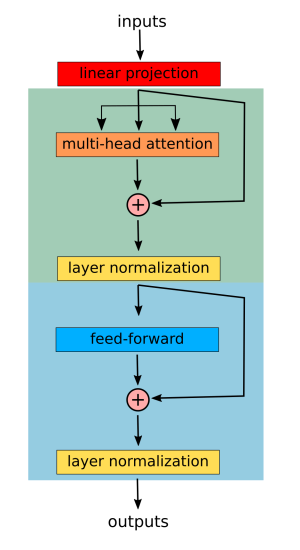

Before the input data is sent to the 'transformer' block, we perform a linear projection of the data into a basic 'representational space' of a specified dimension. This is indicated by the red neural-network layer labelled "linear projection", which is typically implemented as a Dense neural-network layer. This pointwise linear projection simply projects the data (including location information) into whatever dimensionality we specify as the 'representational space' for our sequence data. The only real 'requirement' is that this representational space must match the representational space used by the multi-head attention system and the feed-forward system used later on in the transformer. 

The 'transformer' building-block has 2 main components, highlighted in green and blue, respectively. 

The first component (green) includes the multi-head attention layer, but it looks like there are some other 'weird' bits in there that we haven't seen before.

First, notice that the output of the linear-projection layer is split into 3 replicated pieces, before sending the data to the multi-head attention layer. This 3-way 'split' is required to use the *same* sequence data for the queries, keys and values required by multi-head attention.

The multi-head attention layer produces a single output, but notice that 'weird' arrow that goes from the linear-projection layer's output *around* the multi-head attention layer! That arrow that *bypasses* the multi-head attention layer is called a "residual connection". The residual connection represents a *second* path that the information will travel through the network. The output of the linear-projection layer is sent to the multi-head attention layer, but it is *also* replicated and sent *around* the multi-head attention layer.

After multi-head attention produces its output, this output is *combined* with the residual connection via pointwise addition, which is indicated by the pink circle with the "+" sign in it.

These 'residual' connections are common features of many neural network architectures. They help prevent vanishing-gradient problems in deep networks, and they allow neural-network layers to focus more on calculating 'additional' information that can be 'combined' with the input data, rather than requiring each layer in the network to both 'maintain' the current state of the information *and* calculate additional information that might be relevant for classification.

Operationally, the presence of residual connections means that our transformer network is *not* a simple feed-forward network. So, we can no longer use the simple Sequential model in tensorflow to implement our transformer. We'll need to use the more complicated "functional api" to implement our transformer. We'll get to that a bit later on.

Following the residual connection, the transformer architecture applies "layer normalization", which normalizes the output sequences to have mean close to zero and variance close to one. I've never seen a strong justification for using layer normalization in transformers, but they've been in there since the original 2017 paper, although there is [this work](https://arxiv.org/pdf/2002.04745.pdf) suggesting that applying layer normalization *before* multi-head attention might be preferable. In our network, we'll use the 'original' post-mha layer normalization method.

Okay, so that takes care of the multi-head attention 'block' in the network (shown in green in the above figure).

The second 'block' in the transformer architecture is the "feed-forward" block (highlighted in blue), which consists of a "feed-forward" layer, with the *same* residual connection and layer normalization as was applied with the multi-head attention block.

The "feed-forward" layer is simply 2 Dense neural-network layers, with ReLU activation inbetween. This will be 'easy' to  implement in tensorflow. 

## implementing the transformer in tensorflow

To implement the transformer in tensorflow, we'll need to abandon the simple Sequential model and use the 'functional api' to create a more complicated model that can have 3-way splits (for input to the mulit-head attention layers) and 'residual' connections.

The tensorflow 'functional api' is just a programming mechanism for 'connecting' neural-network layers. "API" stands for Application Programming Interface, a general term used to describe a 'specification' for how to program something in a computer. Tensorflow uses the term "functional api" to describe this particular system, because it effectively uses Layer objects *as if* they were python *functions*.

In python, we can 'call' a function by specifying:

    function_name(inputs)

We provide the name of the function, followed by "(", and then list the inputs to the function, followed by ")". We can also 'capture' the *output* of the function like so:

    output = function_name(inputs)

The tensorflow 'functional api' uses a similar 'syntax' to connect neural-network Layer objects together:

    output_layer = layer_specification()(input_layers)

Here, we create a new Layer object using:

    layer_specification()

At the same time, we set the "input_layers" to the newly-created layer, and 'capture' the resulting output in the "output_layer" variable. It'll probably make a bit more sense once we get going.

To get the network started, we *first* need to create a special Input object that will hold the input to the entire network. This Input object is *not* a Layer, it's a tf.keras.Input object. To create such an object, we just need to specify its shape:

    inlayer = tf.keras.Input(shape=XX)

The "shape" option for the tf.keras.Input object is similar to the "input_shape" option we've been using for the first layer in our Sequential models. 

In our case, our data have shape (128,2), so we'll need to specify:

    inlayer = tf.keras.Input(shape=(128,2))

to create the Input for our functional model.

Next, we need to implement the linear-projection layer, which will 'project' our data up into whatever representational space we want.

Let's first define the dimensionality of our representational space:

    repdim = 4

Then we can use a Dense layer to perform the linear projection:

    proj = tf.keras.layers.Dense(units=repdim)(inlayer)

Notice that the layer specification is just creating a Dense layer with "repdim" units:

    tf.keras.layers.Dense(units=repdim)

where repdim=4, in our case.

But then, we 'connect' this Dense layer to our Input object by appending the:

    (inlayer)

code to the end of our layer specification, so the new Dense layer will take the "inlayer" Input we just created as *input*.

Finally, we capture the *output* of our new Dense layer in the variable "proj", so we can use it later on as *input* to other layers in the network.

XX - mha block

In [4]:
# build model using functional api
repdim = 8

inlayer = tf.keras.Input(shape=(128,2))
proj = tf.keras.layers.Dense(units=repdim)(inlayer)
mha1 = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=repdim)(proj,proj,proj)
res1 = tf.keras.layers.Add()([proj, mha1])
nrm1 = tf.keras.layers.LayerNormalization()(res1)
ffa1 = tf.keras.layers.Dense(units=repdim, activation=tf.keras.activations.relu)(nrm1)
ffb1 = tf.keras.layers.Dense(units=repdim)(ffa1)
res2 = tf.keras.layers.Add()([nrm1, ffb1])
nrm2 = tf.keras.layers.LayerNormalization()(res2)
flt = tf.keras.layers.Flatten()(nrm2)
outlayer = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid)(flt)

model = tf.keras.Model(inputs=inlayer, outputs=outlayer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 2)]     0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128, 8)       24          input_2[0][0]                    
__________________________________________________________________________________________________
multi_head_attention_1 (MultiHe (None, 128, 8)       1128        dense_2[0][0]                    
                                                                 dense_2[0][0]                    
                                                                 dense_2[0][0]                    
______________________________________________________________________________________________

In [5]:
# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# fit model
model.fit(train_data, epochs=20, validation_data=valid_data)

Epoch 1/20
957/957 [==============================] - 20s 15ms/step - loss: 0.4024 - accuracy: 0.8142 - val_loss: 0.3374 - val_accuracy: 0.8560
Epoch 2/20
957/957 [==============================] - 14s 14ms/step - loss: 0.3113 - accuracy: 0.8694 - val_loss: 0.3070 - val_accuracy: 0.8756
Epoch 3/20
957/957 [==============================] - 14s 14ms/step - loss: 0.2835 - accuracy: 0.8822 - val_loss: 0.2895 - val_accuracy: 0.8846
Epoch 4/20
957/957 [==============================] - 14s 14ms/step - loss: 0.2691 - accuracy: 0.8902 - val_loss: 0.2801 - val_accuracy: 0.8902
Epoch 5/20
957/957 [==============================] - 14s 15ms/step - loss: 0.2604 - accuracy: 0.8941 - val_loss: 0.2723 - val_accuracy: 0.8944
Epoch 6/20
957/957 [==============================] - 14s 14ms/step - loss: 0.2547 - accuracy: 0.8965 - val_loss: 0.2675 - val_accuracy: 0.8947
Epoch 7/20
957/957 [==============================] - 14s 14ms/step - loss: 0.2508 - accuracy: 0.8979 - val_loss: 0.2646 - val_accuracy: